# **0. Importación de Librerías**

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# **1. Carga del Dataset**

In [ ]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv"

try:
    df = pd.read_csv(url)
    print("Dataset cargado correctamente.")
except Exception as e:
    print(f"Error al cargar: {e}")

## *1.1. Selección de Columnas de interés*

In [6]:
X = df[['Latitude', 'Longitude', 'MedInc']]

print(f"\nDimensiones del dataset filtrado: {X.shape}")


Dimensiones del dataset filtrado: (20640, 3)


## *1.2. División en Train y Test*

In [9]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

print("\nDivisión de Datos")
print(f"- X_train shape: {X_train.shape}")
print(f"- X_test shape: {X_test.shape}")

print(X_train.head())


División de Datos
- X_train shape: (16512, 3)
- X_test shape: (4128, 3)
       Latitude  Longitude  MedInc
14196     32.71    -117.03  3.2596
8267      33.77    -118.16  3.8125
17445     34.66    -120.48  4.1563
14265     32.69    -117.11  1.9425
2271      36.78    -119.80  3.5542


# **2. Entrenamiento de K-Means**

In [10]:
# Entrena K-Means
kmeans = KMeans(n_clusters=6, random_state=42)

kmeans.fit(X_train)

# Almacena el cluster en el dataframe

X_train_clustered = X_train.copy()
X_train_clustered['cluster'] = kmeans.labels_

# Convierte la columna `cluster` a categoría para que el gráfico las trate como etiquetas.
X_train_clustered['cluster'] = X_train_clustered['cluster'].astype('category')

print("\nDistribución de Clusters (Conteo de casas por grupo)")
print(X_train_clustered['cluster'].value_counts())


Distribución de Clusters (Conteo de casas por grupo)
cluster
3    4368
5    4356
1    3807
0    2455
2    1280
4     246
Name: count, dtype: int64


## *2.1. Scatterplot*

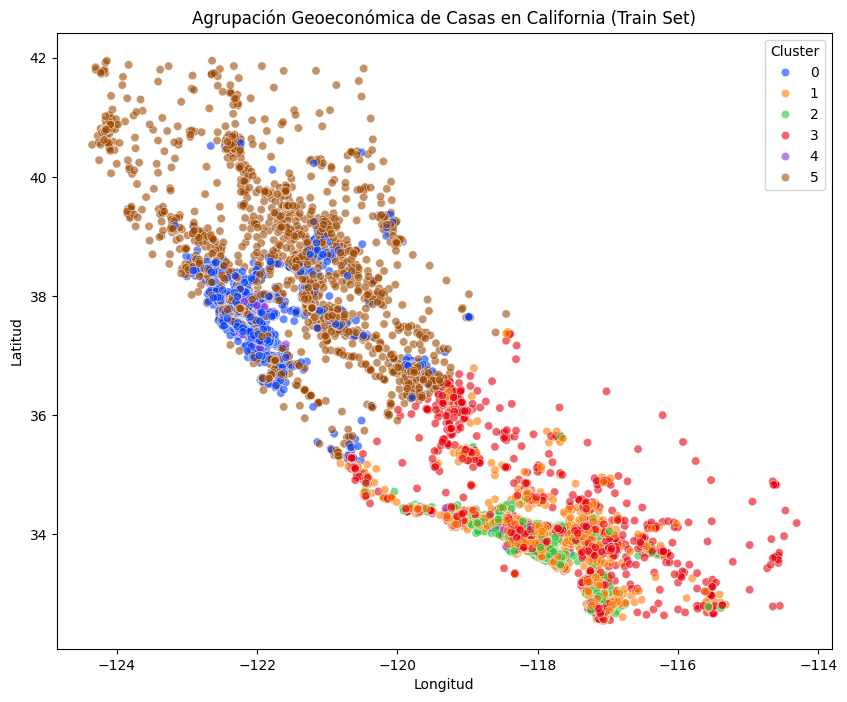

In [12]:
plt.figure(figsize=(10, 8))

sns.scatterplot(data=X_train_clustered, 
                x='Longitude', 
                y='Latitude', 
                hue='cluster', 
                palette='bright', 
                alpha=0.6) 

plt.title('Agrupación Geoeconómica de Casas en California (Train Set)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Cluster')
plt.savefig('clusters_california_train.png')
plt.show()

# **3. Predicción de clusters para el conjunto de TEST**

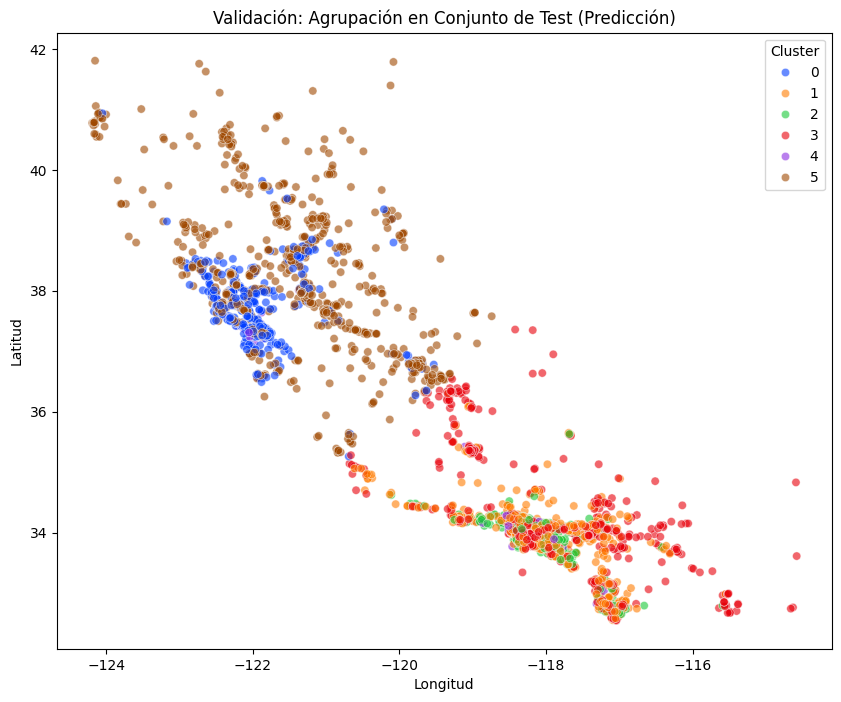

In [15]:
labels_test = kmeans.predict(X_test)

# Prepara los datos para graficar
X_test_clustered = X_test.copy()
X_test_clustered['cluster'] = labels_test
X_test_clustered['cluster'] = X_test_clustered['cluster'].astype('category')

# Grafica el conjunto de TEST
plt.figure(figsize=(10, 8))

sns.scatterplot(data=X_test_clustered, 
                x='Longitude', 
                y='Latitude', 
                hue='cluster', 
                palette='bright', 
                alpha=0.6)

plt.title('Validación: Agrupación en Conjunto de Test (Predicción)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Cluster')
plt.savefig('clusters_california_test.png')
plt.show()

# **4. Clasificación Supercisada con Random Forest**

## *4.1. Preparación de X*

In [16]:

# Train (`Cluster` es la nueva 'y')

y_train_cluster = X_train_clustered['cluster'] 

# Test (`Cluster` es la nueva 'y')

y_test_cluster = X_test_clustered['cluster'] 

## *4.2. Entrenamiento del modelo*

In [17]:
# Eentrena el Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train_cluster)

# Predicciones y Evaluación
rf_y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test_cluster, rf_y_pred)

print(f"\nResultados del Random Forest")
print(f"- Precisión (Accuracy): {accuracy:.4f}")

print("\nReporte de Clasificación:")

target_names = [f'Cluster {i}' for i in range(6)]
print(classification_report(y_test_cluster, rf_y_pred, target_names=target_names))


Resultados del Random Forest
- Precisión (Accuracy): 0.9956

Reporte de Clasificación:
              precision    recall  f1-score   support

   Cluster 0       0.99      0.99      0.99       561
   Cluster 1       0.99      1.00      1.00       983
   Cluster 2       0.99      1.00      0.99       299
   Cluster 3       1.00      1.00      1.00      1111
   Cluster 4       0.98      0.97      0.98        62
   Cluster 5       1.00      0.99      1.00      1112

    accuracy                           1.00      4128
   macro avg       0.99      0.99      0.99      4128
weighted avg       1.00      1.00      1.00      4128



# **5. Guardado del modelo**

In [18]:
# Guarda el modelo de Clasificación
joblib.dump(rf_model, "random_forest_cluster_classifier.pkl")
print("Modelo Random Forest de Clasificación guardado.")

Modelo Random Forest de Clasificación guardado.


# **6. Conclusiones finales**

- **Etiquetas Definidas por Características:** Las etiquetas (cluster 0 a 5) fueron creadas por K-Means, que es un modelo que agrupa puntos basándose en la distancia geométrica en el espacio de características (`Latitude`, `Longitude`, `MedInc`).

- **Aprendizaje Sencillo:** El Random Forest fue entrenado para replicar las reglas de separación del K-Means. El modelo simplemente aprendió que si una casa está en cierto rango de `Latitud`/`Longitud` y tiene un Ingreso Medio (`MedInc`) específico, siempre pertenecerá al mismo cluster. Las "reglas" encontradas de K-Means son fáciles de replicar con un modelo de árboles.

- **Alta Precisión**: La alta precisión del $99.56\%$ valida el flujo de trabajo: se ha utilizado K-Means para etiquetar automáticamente los datos, y luego se ha entrenado un Random Forsest para replicar y predecir esas etiquetas con una efectividad máxima. Ahora, este modelo RF puede predecir el "tipo de cluster" de cualquier casa nueva en California con una alta fiabilidad, basándose únicamente en sus coordenadas y el ingreso medio.